In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

## Multiple Linear Regression

#### Perform multiple regression using the wine dataset provided available in your repo with the goal to predict alcohol level in a wine.

In [3]:
wine = pd.read_csv("data/winequality-white.csv", sep=";")

Designate Variables

In [4]:
X = wine.drop('alcohol', axis=1)
y = wine.alcohol

Split training/testing data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Linear Regression Model

In [6]:
lin_model = LinearRegression()

In [7]:
lin_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Make Predictions with test set

In [8]:
preds = lin_model.predict(X_test)

Visualize prediction results vs test values

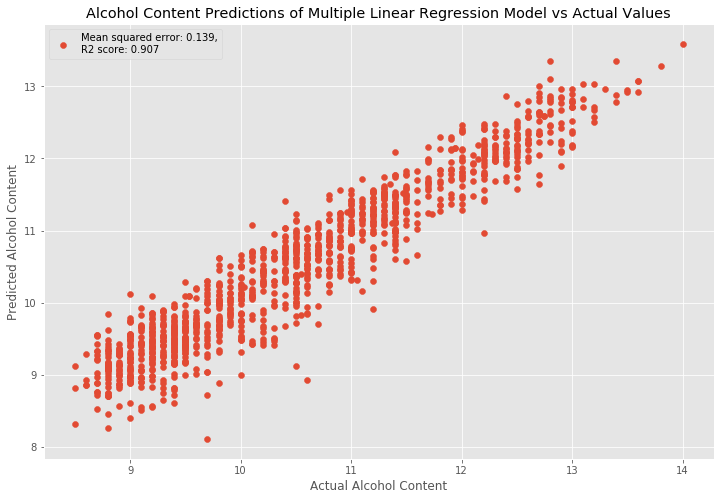

In [9]:
plt.scatter(y_test, preds, 
            label="Mean squared error: {:.3f},\nR2 score: {:.3f}"\
            .format(mean_squared_error(y_test, preds),
                    r2_score(y_test, preds)))
plt.title("Alcohol Content Predictions of Multiple Linear Regression Model vs Actual Values")
plt.xlabel("Actual Alcohol Content")
plt.ylabel("Predicted Alcohol Content")
plt.legend()
None

#### Perform a 5 fold cross validation on this data.

In [10]:
def linreg_kfold(X_, y_, n_folds, random_state=101, kfold = KFold):
    
#   Cross Validation - KFold instance
    kf = kfold(n_splits=n_folds, random_state=random_state)
    
    fold = 0
    mean_error_ = 0
    mean_score_ = 0
    
#   Validate over folds of KFold instance
    for train_index, test_index in kf.split(X_):
        X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
        y_train, y_test = y_[train_index], y_[test_index]

        lin_model = LinearRegression()
        lin_model.fit(X_train, y_train)
        preds = lin_model.predict(X_test)

        mean_squared_ = mean_squared_error(y_test, preds)
        r2_ = r2_score(y_test, preds)
        fold += 1

        mean_error_ += mean_squared_
        mean_score_ += r2_

        print("Fold {}:".format(fold))
        print("\t{}\t{:.3e}".format("Mean Squared Error:".ljust(20), mean_squared_))
        print("\t{}\t{:.3e}".format("R2 score:".ljust(20), r2_))

    mean_error_ /= n_folds
    mean_score_ /= n_folds
    
    return (mean_error_, mean_score_)

In [11]:
X = wine.drop('alcohol', axis=1)
y = wine.alcohol
mean_error_initial, mean_score_initial = linreg_kfold(X, y, 5)

Fold 1:
	Mean Squared Error: 	1.720e-01
	R2 score:           	8.538e-01
Fold 2:
	Mean Squared Error: 	2.108e-01
	R2 score:           	8.371e-01
Fold 3:
	Mean Squared Error: 	4.470e-01
	R2 score:           	6.459e-01
Fold 4:
	Mean Squared Error: 	1.427e-01
	R2 score:           	9.180e-01
Fold 5:
	Mean Squared Error: 	1.289e-01
	R2 score:           	9.192e-01


#### Adjust the model above to replace “chlorides” feature with 1/chlorides and compare the results to model above. Does the prediction get better or worse? If so, by how much %?

In [12]:
X_mod = X.assign(chlorides = X.chlorides.apply(lambda x: 1/x))

In [13]:
mean_error_mod, mean_score_mod = linreg_kfold(X_mod, y, 5)

Fold 1:
	Mean Squared Error: 	1.718e-01
	R2 score:           	8.539e-01
Fold 2:
	Mean Squared Error: 	2.111e-01
	R2 score:           	8.368e-01
Fold 3:
	Mean Squared Error: 	4.442e-01
	R2 score:           	6.481e-01
Fold 4:
	Mean Squared Error: 	1.406e-01
	R2 score:           	9.192e-01
Fold 5:
	Mean Squared Error: 	1.291e-01
	R2 score:           	9.192e-01


In [14]:
print("After replacing the 'chlorides' feature with its reciprocal:")
print("Difference in Mean Squared Error overall: {:.3e}%".format(100*(mean_error_mod - mean_error_initial)))
print("Difference in R2 score overall: {:.3e}".format(mean_score_mod - mean_score_initial))

After replacing the 'chlorides' feature with its reciprocal:
Difference in Mean Squared Error overall: -8.972e-02%
Difference in R2 score overall: 6.288e-04


There is a slight improvement of the mean squared error, but the R<sup>2</sup> value is essentially unchanged. 

---

### Bonus

#### Apply Box-Cox Transform to the data and compare the updated results to the original results

In [15]:
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import boxcox
import numpy as np

In [16]:
trans = FunctionTransformer(boxcox)

In [17]:
pos_wine = wine.copy()

In [18]:
# keep rows with values greater than min value - ensure all values are positive and greater than min
minimum = 0.001
for cols in pos_wine.columns:
    pos_wine = pos_wine.loc[pos_wine[cols] > minimum]

In [28]:
# Apply boxcox transform to columns of pos_wine
# trans_df = pd.DataFrame(columns = pos_wine.columns)
# for col in pos_wine.colubmns:
#     trans_df[col], _ = boxcox(pos_wine[col])

# Alternative application of boxcox transform to columns of pos_wine
trans_df = pos_wine.transform(lambda x: boxcox(x)[0])

In [21]:
X_trans = trans_df.drop(['alcohol'], axis=1).reset_index()
y_trans = trans_df.alcohol

In [23]:
n_folds = 5
mean_error_boxcox, mean_score_boxcox = linreg_kfold(X_trans, y_trans.values, n_folds)

Fold 1:
	Mean Squared Error: 	1.817e-06
	R2 score:           	8.314e-01
Fold 2:
	Mean Squared Error: 	2.256e-06
	R2 score:           	7.950e-01
Fold 3:
	Mean Squared Error: 	1.878e-06
	R2 score:           	8.302e-01
Fold 4:
	Mean Squared Error: 	1.495e-06
	R2 score:           	8.843e-01
Fold 5:
	Mean Squared Error: 	1.592e-06
	R2 score:           	8.729e-01


#### Write a k-fold validator and compare results with the standard k-fold validator

In [25]:
from numpy.random import RandomState

class MyRandom:
    
    def __init__(self, random_state):
        self._random = RandomState(random_state)
        self.choice = self._random.choice     
    
class MyKFold:
                   
    def __init__(self, n_splits=3, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random = MyRandom(random_state)
        self._train_size = 0.65
        self._test_size = None
               
    def get_n_splits(self) -> int:
        """ Return number of splitting iterations in cross-validator """
        return self.n_folds
    
    def split(self, X, y=None, groups=None) -> tuple:
        """ Generate indices for splitting data into training and testing sets """
        
        index = []
        # TODO: check type of X - handling index values
        if type(X) == pd.DataFrame:
            index = X.index
        elif type(X) == list:
            pass
        
        if y is None:
            ix = int(self._train_size * max(X.index))
        else:
            # TODO: Update to appropriate functionality
            pass
        
        splits = [int(i*len(index)*self._train_size/(self.n_splits)) for i in range(self.n_splits)]
        splits.append(len(index)-1)
        for i in range(len(splits)-1):
            
            test_index = index.values[splits[i]:splits[i+1]]
            train_index = list(filter(lambda x: x not in test_index, index))
            
            if self.shuffle:
                train = self.random.choice(train_index, size=len(train_index)-1, replace=False)
                test = self.random.choice(test_index, size=len(test_index)-1, replace=False)
            else:
                train = sorted(train_index)
                test = sorted(test_index)
            
            yield (train, test)

In [26]:
my_kf = MyKFold()

In [27]:
mean_error_mykf, mean_score_mykf = linreg_kfold(X_trans, y_trans.values, n_folds, kfold = MyKFold)

Fold 1:
	Mean Squared Error: 	1.666e-06
	R2 score:           	8.474e-01
Fold 2:
	Mean Squared Error: 	1.838e-06
	R2 score:           	8.239e-01
Fold 3:
	Mean Squared Error: 	2.158e-06
	R2 score:           	8.109e-01
Fold 4:
	Mean Squared Error: 	1.622e-06
	R2 score:           	8.277e-01
Fold 5:
	Mean Squared Error: 	1.874e-06
	R2 score:           	8.534e-01
